In [108]:
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import seaborn as sns
import itertools
import pyemma as pm

In [123]:
sim = 'transition_state'
data_dir  = f'final_bootstraps/{sim}'

In [124]:
dt = 0.1
mod = pickle.load(open(data_dir+'/model_bs_0.p', 'rb'))
lag = (mod['model'].lag*dt)

In [125]:
def plot_ck(pred, est, lags, axes, est_kwargs, pred_kwargs):
    axes = axes.flatten()
    pred = pred.reshape(pred.shape[0], -1)
    est = est.reshape(est.shape[0], -1)
    for i in range(axes.shape[0]):
        ax = axes[i]
        ax.plot(lags, pred[i], **pred_kwargs)
        ax.plot(lags, est[i], **est_kwargs)
        
        

In [126]:
mods = [pickle.load(x.open('rb')) for x in Path(data_dir).glob('*.p')]

In [127]:
preds = np.concatenate([x['ck_pred'][np.newaxis, ...] for x in mods], axis=0)
ests = np.concatenate([x['ck_est'][np.newaxis, ...] for x in mods], axis=0)

In [128]:
def quantile(vals, q=0.5):
    vals = np.concatenate([x[np.newaxis, ...] for x in vals[:, ...] if np.sum(np.isnan(x))==0], axis=0)
    tmp = np.quantile(vals, q=q, axis=0)
    tmp = tmp.reshape(tmp.shape[0], -1)
    return tmp

In [129]:
preds_m = quantile(preds)
preds_lb = quantile(preds, q=0.025)
preds_ub = quantile(preds, q=0.975)

ests_m = quantile(ests)
ests_lb = quantile(ests, q=0.025)
ests_ub = quantile(ests, q=0.975)

lags = lag*np.arange(6)

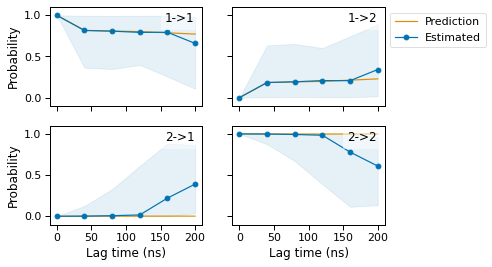

In [130]:
with sns.plotting_context('paper', font_scale=1.25):
    fig, axes = plt.subplots(*preds.shape[-2:], sharex=True, sharey=True)

    cols = sns.color_palette('colorblind')
    delta_y = 0.1
    pred_col = cols[1]
    est_col = cols[0]
    
    
    for i, ax in enumerate(axes.flatten()):
        ax.plot(lags, preds_m[:lags.shape[0], i], color=pred_col, label='Prediction')
        ax.plot(lags, ests_m[:lags.shape[0], i], color=est_col, label='Estimated', marker='o')
        ax.fill_between(lags, ests_lb[:lags.shape[0], i], ests_ub[:lags.shape[0], i], alpha=0.1, color=est_col)
        
        x, y = np.unravel_index(indices=i, shape=(2, 2))
        ax.annotate(text=f"{x+1}->{y+1}", xy=(0.95, 0.95), ha='right', va='top', xycoords='axes fraction', bbox={'facecolor': 'w', 'edgecolor': 'w', 'alpha': 0.5})
        
        
        ax.set_ylim(-delta_y, 1+delta_y)
        if i //2 == 1:
            ax.set_xlabel('Lag time (ns)')
        if i % 2 == 0:
            ax.set_ylabel('Probability')
        if i == 1:
            ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.savefig(f'figures/ck_test_{sim}.pdf', bbox_inches='tight')